## Problem statement: To build a CNN based model which can accurately detect melanoma.

**1. Data Reading/Data Understanding**
→ Defining the path for train and test images


In [1]:
#mount google drive
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [2]:
#unzip the dataset from google drive
!unzip "/content/gdrive/MyDrive/CNN_assignment.zip" > /dev/null


In [13]:
#import the required libraries
import pathlib
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.preprocessing.image import load_img

In [4]:
# Defining the path for train and test images from google drive
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [5]:
# Count the number of image in Train and Test directory Using the glob to retrieve files/pathnames matching a specified pattern.

#Train
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

#Test
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


**2. Dataset Creation**→ Create train & validation dataset from the train directory with a batch size of 32. Also, make sure you resize your images to 180*180.

In [6]:
#Visualize one instance of all the class present in the dataset.

#image_dataset_from_directory() will return a tf.data.Dataset that yields batches of images from the subdirectories.
#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size=(180,180),label_mode='categorical',seed=123)

#all the classes of Skin Cancer
class_names = image_dataset.class_names

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))


Found 2239 files belonging to 9 classes.



**3. Dataset visualisation** → Create a code to visualize one instance of all the nine classes present in the dataset

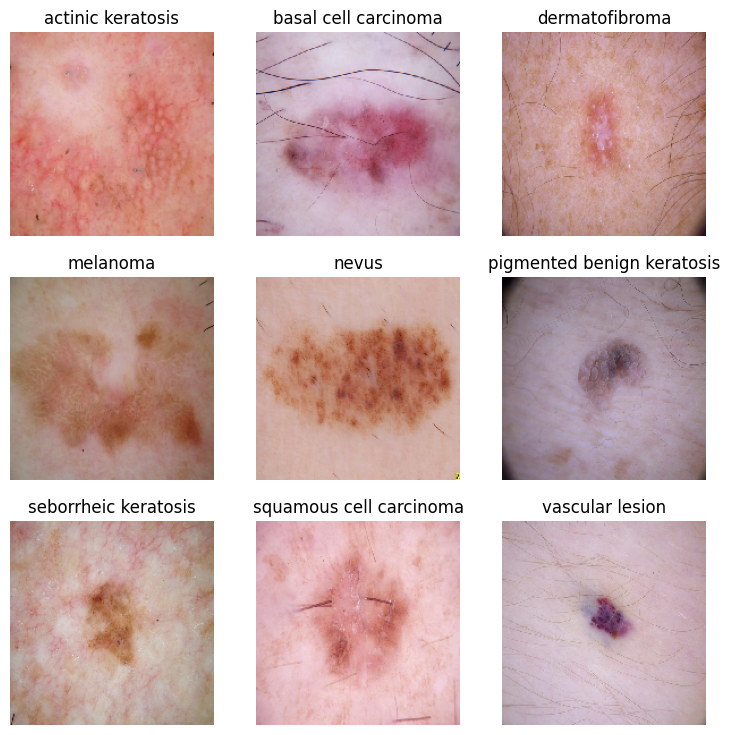

In [9]:
#Visualize images from each folder
plt.figure(figsize=(9,9))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

In [12]:
# Visualize distribution of classes in the training dataset.*italicized text*

def class_distribution_count(directory):

    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'Count'])

df = class_distribution_count(data_dir_train)
print(df)

                        Class  Count
0                    melanoma    438
1  pigmented benign keratosis    462
2     squamous cell carcinoma    181
3        basal cell carcinoma    376
4        seborrheic keratosis     77
5              dermatofibroma     95
6                       nevus    357
7             vascular lesion    139
8           actinic keratosis    114


**4. Class distribution:** → Examine the current class distribution in the training dataset

<Axes: xlabel='Count', ylabel='Class'>

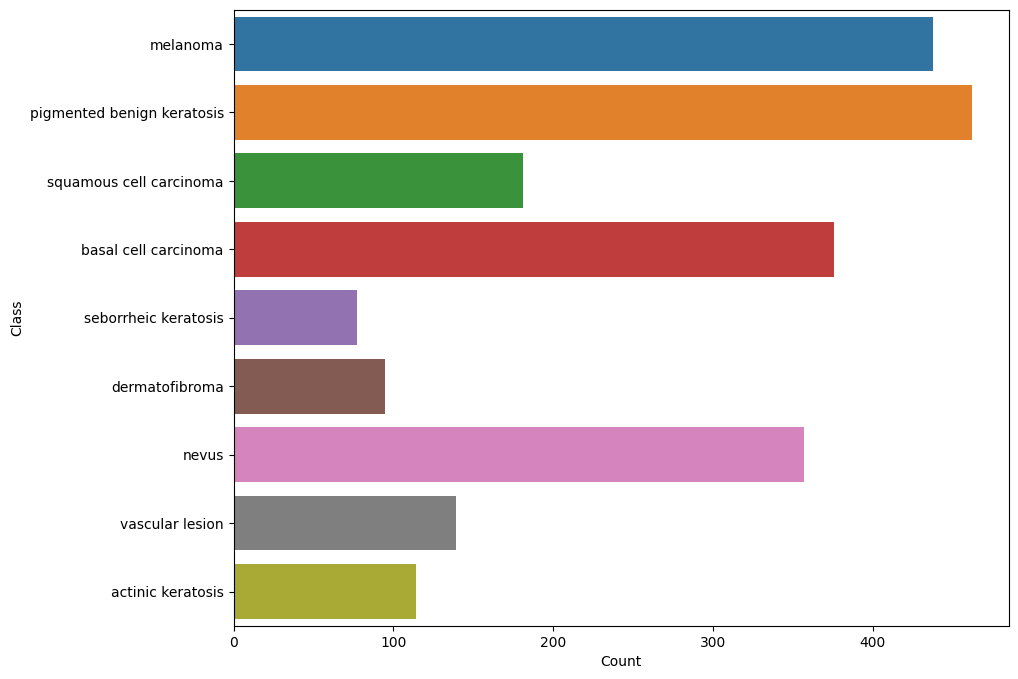

In [16]:
#Visualize the Number of image in each class using seaborn bar graphs
plt.figure(figsize=(10, 8))
sns.barplot(x="Count", y="Class", data=df, label="Class")

**5. Handling class imbalances:** → Rectify class imbalances present in the training dataset with Augmentor library.

**6. Class distribution:** → Examine the current class distribution in the training dataset

**7. Chose an appropriate data augmentation strategy**  to resolve underfitting/overfitting


In [17]:
#install Augmentor
!pip install Augmentor

In [18]:
# Adding 500 samples per class to make sure that none of the classes are sparse in training dataset

path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78F4697F2A40>: 100%|██████████| 500/500 [00:16<00:00, 29.71 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78F465DA7910>: 100%|██████████| 500/500 [00:15<00:00, 31.95 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x78F4696DD150>: 100%|██████████| 500/500 [00:17<00:00, 28.36 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x78F4697F28C0>: 100%|██████████| 500/500 [01:22<00:00,  6.06 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x78F469685930>: 100%|██████████| 500/500 [01:23<00:00,  6.02 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78F4697F2950>: 100%|██████████| 500/500 [00:15<00:00, 32.18 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x78F469685930>: 100%|██████████| 500/500 [00:37<00:00, 13.27 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78F4697F2920>: 100%|██████████| 500/500 [00:15<00:00, 31.27 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78F4E3F4BD90>: 100%|██████████| 500/500 [00:17<00:00, 28.85 Samples/s]


In [19]:
#Count total number of image generated by Augmentor.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


**8. Model Building & training on the augmented data :**

In [20]:
# train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes),
#representing a one-hot encoding of the class index.

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [21]:
# validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [22]:
#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.
AUTOTUNE = tf.data.experimental.AUTOTUNE

#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [23]:
# Create a CNN model, which can accurately detect 9 classes present in the dataset. While building the model rescale images to normalize pixel values between (0,1).

#Sequential allows you to create models layer-by-layer
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

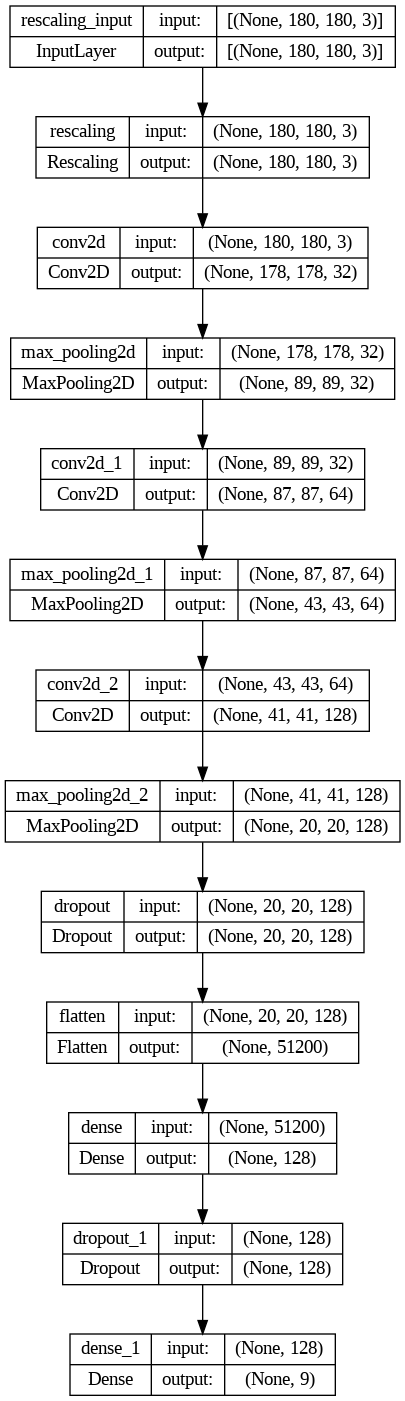

In [24]:
# vizualizing the model
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [25]:
#Compile the Model

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

In [26]:
# Train the model
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/20
169/169 [==============================] - ETA: 0s - loss: 1.8506 - accuracy: 0.2969
Epoch 1: val_accuracy improved from -inf to 0.45212, saving model to model.h5
169/169 [==============================] - 41s 91ms/step - loss: 1.8506 - accuracy: 0.2969 - val_loss: 1.5014 - val_accuracy: 0.4521
Epoch 2/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


169/169 [==============================] - ETA: 0s - loss: 1.5055 - accuracy: 0.4262
Epoch 2: val_accuracy did not improve from 0.45212
169/169 [==============================] - 10s 56ms/step - loss: 1.5055 - accuracy: 0.4262 - val_loss: 1.4282 - val_accuracy: 0.4395
Epoch 3/20
169/169 [==============================] - ETA: 0s - loss: 1.3097 - accuracy: 0.4948
Epoch 3: val_accuracy improved from 0.45212 to 0.55679, saving model to model.h5
169/169 [==============================] - 10s 59ms/step - loss: 1.3097 - accuracy: 0.4948 - val_loss: 1.1947 - val_accuracy: 0.5568
Epoch 4/20
169/169 [==============================] - ETA: 0s - loss: 1.2134 - accuracy: 0.5402
Epoch 4: val_accuracy did not improve from 0.55679
169/169 [==============================] - 9s 52ms/step - loss: 1.2134 - accuracy: 0.5402 - val_loss: 1.2296 - val_accuracy: 0.5427
Epoch 5/20
169/169 [==============================] - ETA: 0s - loss: 1.1390 - accuracy: 0.5734
Epoch 5: val_accuracy improved from 0.55679 to

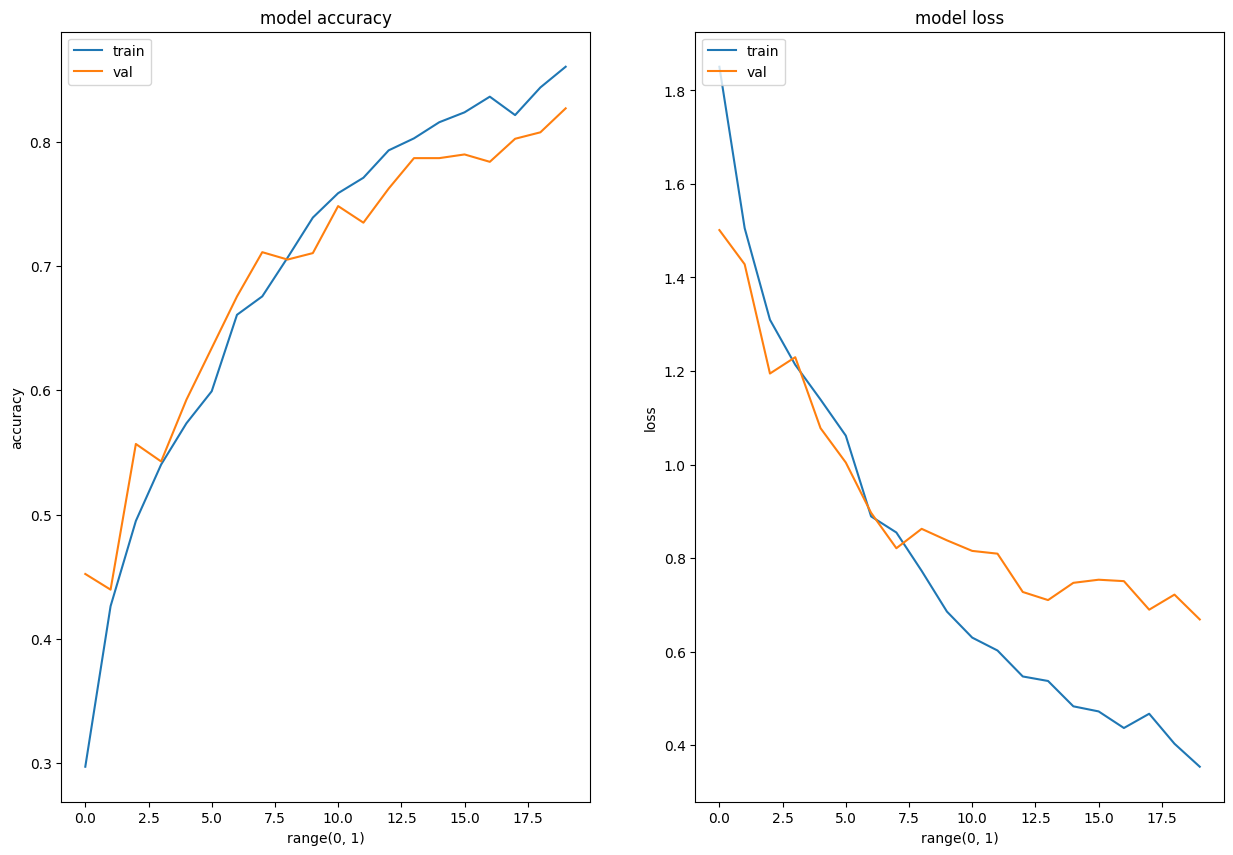

In [28]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()


## Model Prediction

**9. Model Building & training on the rectified class imbalance data**

1/1 [==============================] - 0s 27ms/step
Actual Class basal cell carcinoma
Predictive Class basal cell carcinoma


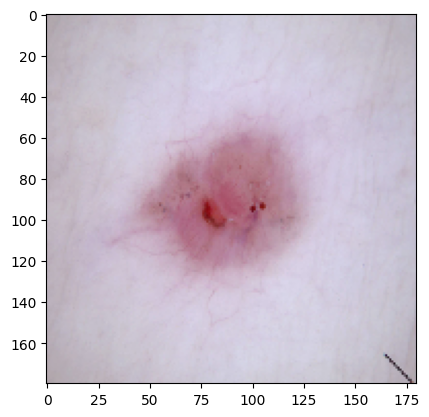

In [32]:
from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )